# ConvNets Assignment

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

This classification assignment will use the CIFAR 10 library which is part of Keras.https://keras.io/api/datasets/cifar10/ and https://www.cs.toronto.edu/~kriz/cifar.html. CIFAR 10 is a collection of 50,000 training and 10,000 test images of 10 differnt classes of objects.  Using convolutional neural networks (convets, or CNN) to get the model accuracy above 80%

In [2]:
# Load the libraries
from functools import partial

import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

2025-02-04 10:59:12.377686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738634352.391630   25121 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738634352.395383   25121 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 10:59:12.410313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [4]:
# Load the CIFAR 10 library from Keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

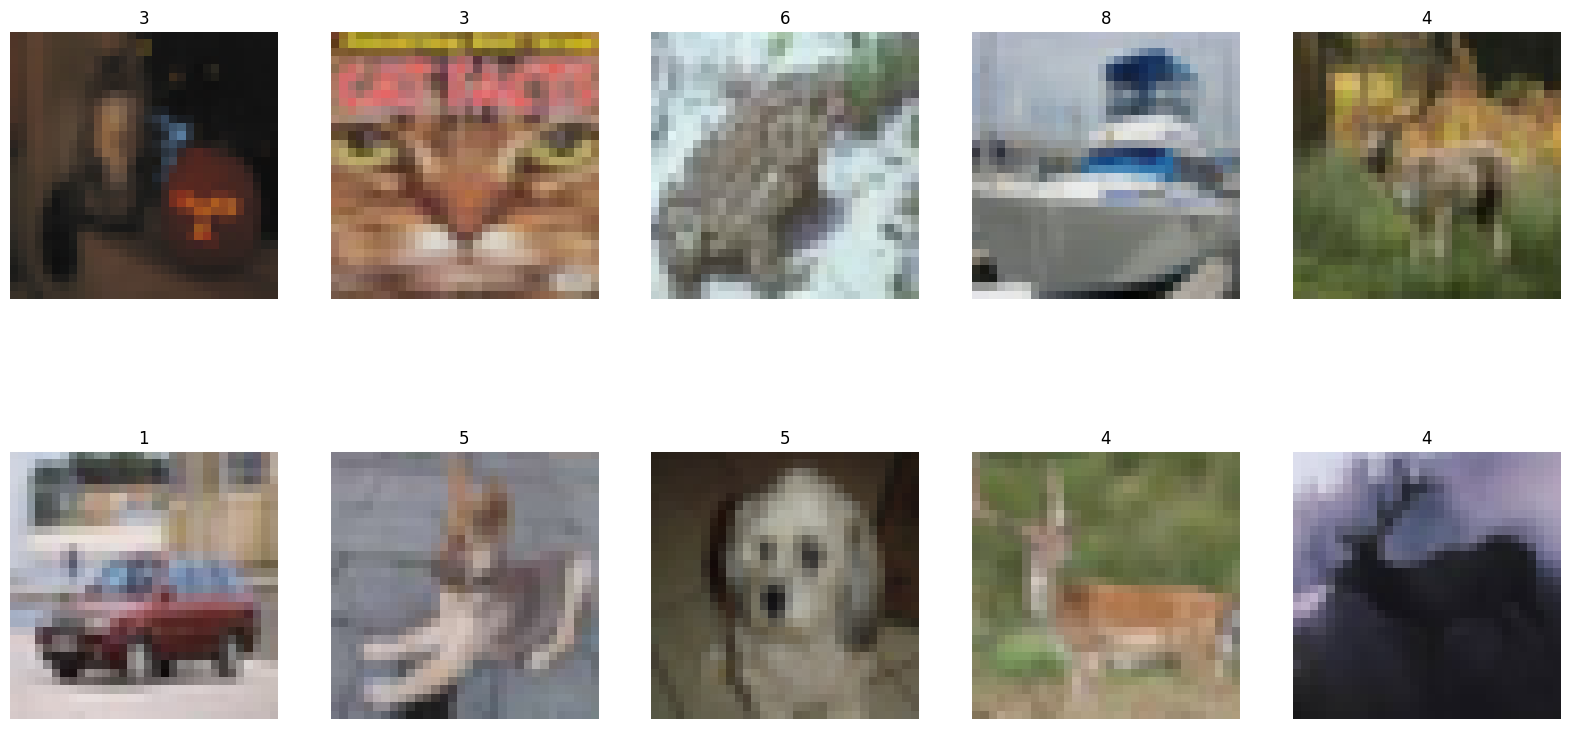

In [5]:
# View a few of the images
rand_idx = np.random.randint(0, x_train.shape[0], 10)
plt.figure(figsize=(20, 10))
for i, idx in enumerate(rand_idx):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[idx])
    plt.title(y_train[idx][0])
    plt.axis('off')

In [6]:
# Prepare the train and test images for a CNN
batch_size = 64

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1738634357.083302   25121 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:10:00.0, compute capability: 8.9


In [7]:
# Create a plot funtion like we did in the walk-though
def plot_history(history):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Print best validation accuracy and its epoch
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = history.history['val_accuracy'][best_epoch]
    print(f'Best validation accuracy: {best_val_acc} at epoch {best_epoch}')

### Review literature for CNN architectures and build at least 3 different architectures with varying depths, kernels, and normalization functions.  Be sure to split your data into a validation block and monitor loss and accuracy with graphs.  Build, compile, monitor, validate, and test each CNN architecture in one cell.  Try to get one of your CNN architectures to have a test accauracy above 80%.  Plot your models to verify your arcitecture is correct.
      
#### Here are is a link that reviews different CNN architectures.
#### https://medium.com/datadriveninvestor/five-powerful-cnn-architectures-b939c9ddd57b 

This function will build residual blocks to make resnet like Convolutional models.

In [8]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, padding='same', kernel_initializer='he_normal')

def residual_block(x, filters, kernel_size=3, stride=1):
    y = DefaultConv2D(filters, kernel_size=kernel_size, strides=stride)(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.ReLU()(y)
    y = DefaultConv2D(filters, kernel_size=kernel_size)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    if stride > 1 or x.shape[-1] != filters:
        x = DefaultConv2D(filters, kernel_size=1, strides=stride)(x)
    out = tf.keras.layers.Add()([x, y])
    return tf.keras.layers.ReLU()(out)

# Model 1

In [ ]:
tf.keras.backend.clear_session()

inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = residual_block(inputs, 64)
x = residual_block(x, 64)
x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
X = tf.keras.layers.Dense(10)(x)
outputs = tf.keras.layers.Softmax(dtype='float32')(x)
model1 = tf.keras.Model(inputs, outputs)
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 32, 32, 3) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ cast[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 32, 32, 3) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │        256 │ cast_1[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ conv2d_2[0][0],   │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ re_lu_1[0][0],    │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 673,856 (2.57 MB)

 Trainable params: 672,320 (2.56 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [10]:
history1 = model1.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5, restore_best_weights=True)])

Epoch 1/100


I0000 00:00:1738634364.227286   25225 service.cc:148] XLA service 0x7ca0640038f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738634364.227316   25225 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-02-04 10:59:24.286813: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738634364.835670   25225 cuda_dnn.cc:529] Loaded cuDNN version 90300


 27/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1897 - loss: 4.3505    

I0000 00:00:1738634369.154201   25225 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3415 - loss: 3.2212

2025-02-04 10:59:33.383547: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_305', 4 bytes spill stores, 4 bytes spill loads

2025-02-04 10:59:33.453921: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_305', 12 bytes spill stores, 12 bytes spill loads

2025-02-04 10:59:34.654965: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_305', 12 bytes spill stores, 12 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.3422 - loss: 3.2186 - val_accuracy: 0.4265 - val_loss: 2.9690
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4937 - loss: 2.6633 - val_accuracy: 0.3688 - val_loss: 3.5156
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5405 - loss: 2.4738 - val_accuracy: 0.5339 - val_loss: 2.6788
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5728 - loss: 2.3372 - val_accuracy: 0.5611 - val_loss: 2.4059
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5923 - loss: 2.2416 - val_accuracy: 0.5271 - val_loss: 2.6528
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6104 - loss: 2.1670 - val_accuracy: 0.5491 - val_loss: 2.5605
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6222 - loss: 2.1013 - val_accuracy: 0.5742 - val_loss: 2.4051
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6352 - loss: 2.0448 - val_accuracy: 0.56

Best validation accuracy: 0.6489999890327454 at epoch 18


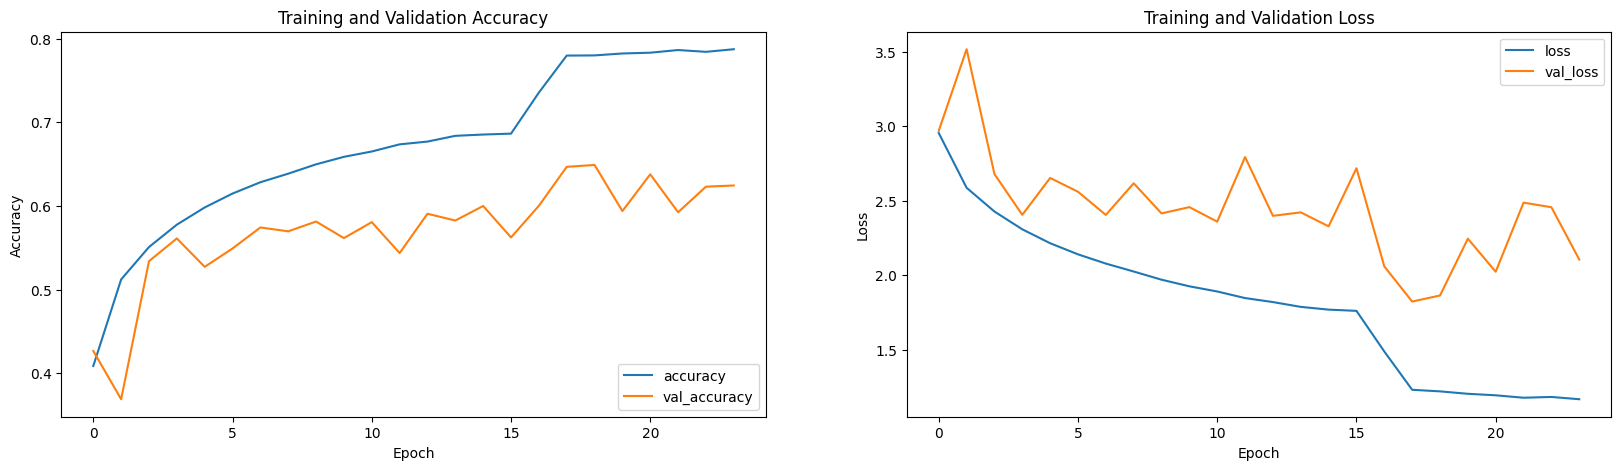

In [11]:
plot_history(history1)

That's not very good, but it looks like the model is too small.

# Model 2

In [12]:


inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = DefaultConv2D(64, kernel_size=3)(inputs)
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)
x = residual_block(x, 128)
x = residual_block(x, 256, stride=2)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(10)(x)
outputs = tf.keras.layers.Softmax(dtype='float32')(x)
model2 = tf.keras.Model(inputs, outputs)
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_3 (Cast)       │ (None, 32, 32, 3) │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │      1,792 │ cast_3[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_10[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_8[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 32, 32,    │          0 │ conv2d_10[0][0],  │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 32, 32,    │          0 │ add_4[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_9[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_10[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 32, 32,    │          0 │ re_lu_9[0][0],    │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 32, 32,    │          0 │ add_5[0][0]       │
│                     │ 64)               │            │                 

 Total params: 4,401,162 (16.79 MB)

 Trainable params: 4,395,786 (16.77 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [13]:
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5, restore_best_weights=True)])

Epoch 1/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4286 - loss: 1.6671

2025-02-04 11:01:25.772059: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_610', 4 bytes spill stores, 4 bytes spill loads

2025-02-04 11:01:26.028879: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_610', 12 bytes spill stores, 12 bytes spill loads

2025-02-04 11:01:27.637383: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_610', 12 bytes spill stores, 12 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.4291 - loss: 1.6654 - val_accuracy: 0.6015 - val_loss: 1.1112
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6925 - loss: 0.8704 - val_accuracy: 0.6973 - val_loss: 0.8614
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7718 - loss: 0.6463 - val_accuracy: 0.7502 - val_loss: 0.7522
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8209 - loss: 0.5171 - val_accuracy: 0.7862 - val_loss: 0.6385
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8617 - loss: 0.3964 - val_accuracy: 0.7601 - val_loss: 0.7976
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8947 - loss: 0.3086 - val_accuracy: 0.7232 - val_loss: 1.0235
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9129 - loss: 0.2457 - val_accuracy: 0.7239 - val_loss: 1.0191
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9355 - loss: 0.1815 - val_accurac

Best validation accuracy: 0.7993999719619751 at epoch 7


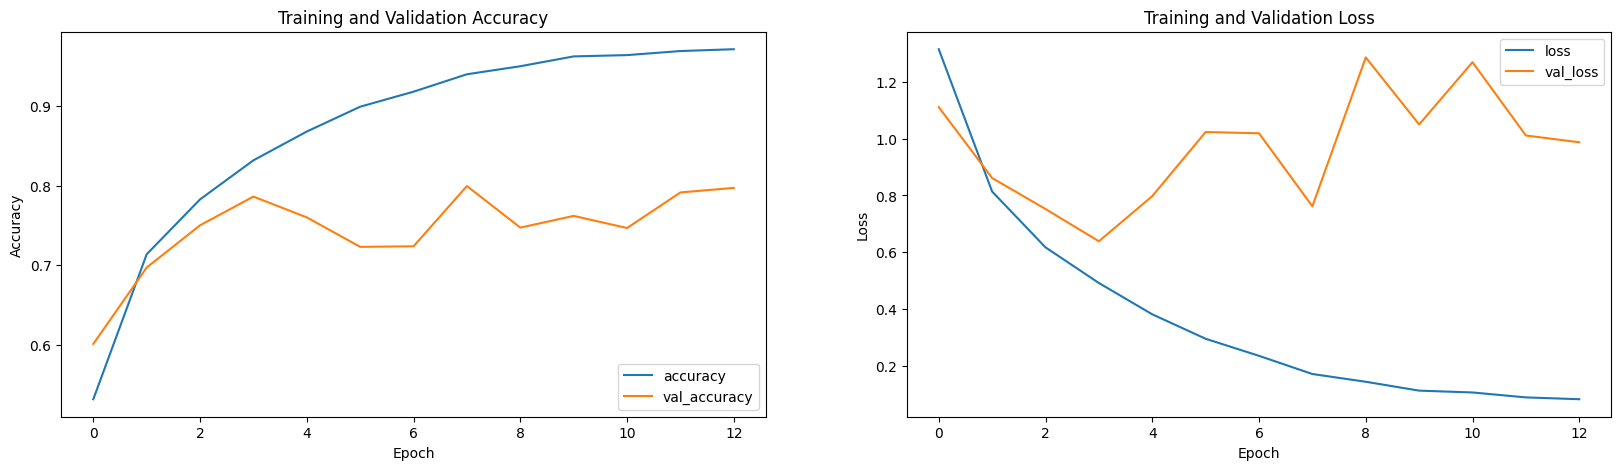

In [14]:
plot_history(history2)

That's a lot better. Almost hit the goal of 80%.

# Model 3

In [15]:
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = DefaultConv2D(64, kernel_size=3)(inputs)
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)
x = residual_block(x, 128)
x = residual_block(x, 128)
x = residual_block(x, 256, stride=2)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10)(x)
outputs = tf.keras.layers.Softmax(dtype='float32')(x)
model3 = tf.keras.Model(inputs, outputs)
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_5 (Cast)       │ (None, 32, 32, 3) │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 32, 32,    │      1,792 │ cast_5[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_31[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_26[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 32, 32,    │          0 │ conv2d_31[0][0],  │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_27 (ReLU)     │ (None, 32, 32,    │          0 │ add_13[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_27[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_28[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 32, 32,    │          0 │ re_lu_27[0][0],   │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 32, 32,    │          0 │ add_14[0][0]      │
│                     │ 64)               │            │                 

 Total params: 6,151,050 (23.46 MB)

 Trainable params: 6,143,882 (23.44 MB)

 Non-trainable params: 7,168 (28.00 KB)

In [16]:
history3 = model3.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5, restore_best_weights=True)])

Epoch 1/100


2025-02-04 11:03:21.201104: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5522', 8 bytes spill stores, 8 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3071 - loss: 2.0660

2025-02-04 11:03:38.149848: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_789', 4 bytes spill stores, 4 bytes spill loads

2025-02-04 11:03:38.447139: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_789', 12 bytes spill stores, 12 bytes spill loads

2025-02-04 11:03:41.084605: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_789', 12 bytes spill stores, 12 bytes spill loads

2025-02-04 11:03:41.206186: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_798', 4 bytes spill stores, 4 bytes spill loads

2025-02-04 11:03:41.219921: I external/local_xla/xla/stream_executor

625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - accuracy: 0.3072 - loss: 2.0653 - val_accuracy: 0.4582 - val_loss: 1.7399
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5570 - loss: 1.2280 - val_accuracy: 0.5521 - val_loss: 1.3627
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6630 - loss: 0.9490 - val_accuracy: 0.6286 - val_loss: 1.0814
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7301 - loss: 0.7872 - val_accuracy: 0.7413 - val_loss: 0.7550
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7779 - loss: 0.6579 - val_accuracy: 0.7226 - val_loss: 0.8875
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8171 - loss: 0.5430 - val_accuracy: 0.7464 - val_loss: 0.7862
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8513 - loss: 0.4473 - val_accuracy: 0.7506 - val_loss: 0.8463
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8737 - loss: 0.3796 - val_

Best validation accuracy: 0.8330000042915344 at epoch 26


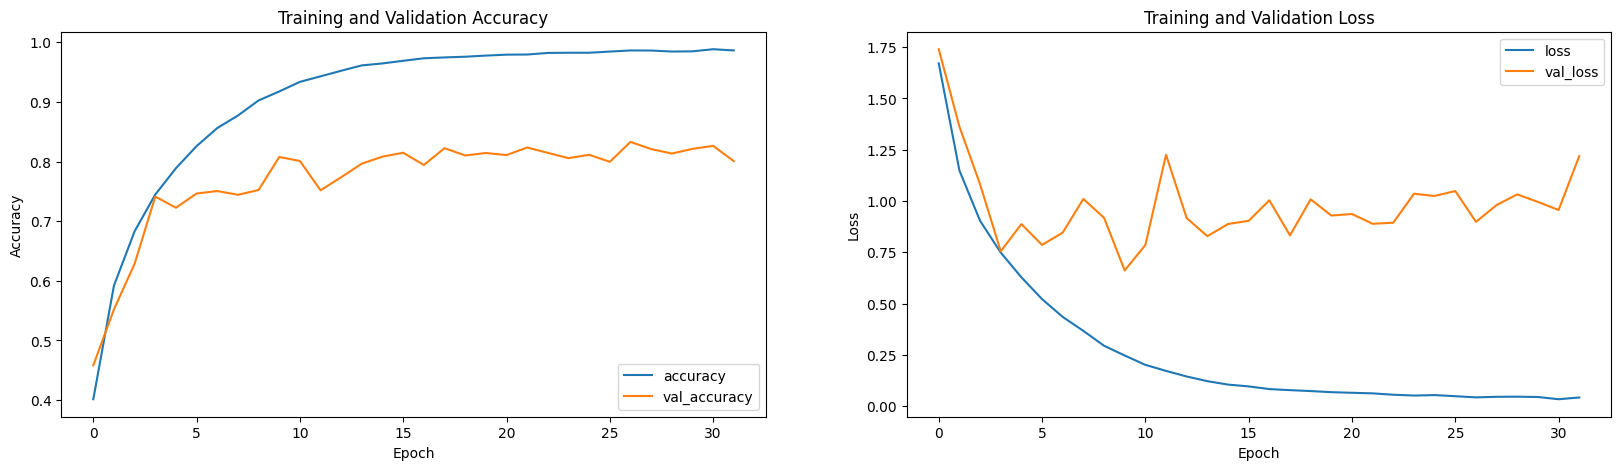

In [17]:
plot_history(history3)

Woot!

# Keras tuner

In [18]:
def resnet_builder(hp):
    n_shrinks = hp.Int('n_shrinks', 1, 2)
    n_blocks = hp.Int('n_blocks', 2, 3)
    n_filters = hp.Int('n_filters', 32, 64, step=2, sampling='log')
    dropout = hp.Float('dropout', 0.0, 0.5, step=0.25)
    augment = hp.Boolean('augment')
    
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    if augment:
        x = tf.keras.layers.RandomFlip('horizontal')(inputs)
        x = tf.keras.layers.RandomRotation(0.1)(x)
        x = tf.keras.layers.RandomZoom(0.1)(x)
        x = DefaultConv2D(n_filters, kernel_size=3)(x)
    else:
        x = DefaultConv2D(n_filters, kernel_size=3)(inputs)
    for i in range(1, n_shrinks + 2):
        for j in range(n_blocks):
            x = residual_block(x, n_filters*i, stride=2 if j == 0 and i > 1 else 1)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    dense_units = n_filters * 2**n_shrinks
    x = tf.keras.layers.Dense(dense_units, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(10)(x)
    outputs = tf.keras.layers.Softmax(dtype='float32')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
# Instantiate the Keras Tuner HyperParameters object
hp = kt.HyperParameters()
print(hp.values)

# Build the model using the resnet_builder function
model = resnet_builder(hp)

# Print the model summary
model.summary()

{}


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_7 (Cast)       │ (None, 32, 32, 3) │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 32, 32,    │        896 │ cast_7[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 32, 32,    │      9,248 │ conv2d_58[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_50 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 32, 32,    │      9,248 │ re_lu_50[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 32, 32,    │          0 │ conv2d_58[0][0],  │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_51 (ReLU)     │ (None, 32, 32,    │          0 │ add_25[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 32, 32,    │      9,248 │ re_lu_51[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_52 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 32, 32,    │      9,248 │ re_lu_52[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_62[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 32, 32,    │          0 │ re_lu_51[0][0],   │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_53 (ReLU)     │ (None, 32, 32,    │          0 │ add_26[0][0]      │
│                     │ 32)               │            │                 

 Total params: 175,626 (686.04 KB)

 Trainable params: 174,858 (683.04 KB)

 Non-trainable params: 768 (3.00 KB)

In [46]:
tuner = kt.BayesianOptimization(resnet_builder, objective='val_accuracy', max_trials=16, hyperparameters=hp)
tuner.search(train_ds, validation_data=val_ds, epochs=12, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=3, restore_best_weights=True)])

Trial 16 Complete [00h 02m 36s]
val_accuracy: 0.7954999804496765

Best val_accuracy So Far: 0.8208000063896179
Total elapsed time: 00h 52m 33s


In [50]:
tuner.oracle.get_best_trials(1)[0].summary()

Trial 06 summary
Hyperparameters:
n_shrinks: 2
n_blocks: 3
n_filters: 64
dropout: 0.5
augment: False
Score: 0.8208000063896179


That took a really long time and I didn't even test that large of models. I just wanted to see if I could make a resnet building function and implement it with keras tuner. If I wanted to spend the time or I had more resources this could be scaled up to include larger models and test more things like kernel size and learning rates.

# Model 4

In [20]:
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = tf.keras.layers.RandomFlip('horizontal')(inputs)
x = tf.keras.layers.RandomRotation(0.1)(x)
x = tf.keras.layers.RandomZoom(0.1)(x)
x = DefaultConv2D(64, kernel_size=3)(x)
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)
x = residual_block(x, 128)
x = residual_block(x, 128)
x = residual_block(x, 256, stride=2)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10)(x)
outputs = tf.keras.layers.Softmax(dtype='float32')(x)
model4 = tf.keras.Model(inputs, outputs)
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model4.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5, restore_best_weights=True)])

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.3140 - loss: 2.1616 - val_accuracy: 0.4130 - val_loss: 1.9374
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.4876 - loss: 1.4153 - val_accuracy: 0.4803 - val_loss: 1.6207
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.5711 - loss: 1.2053 - val_accuracy: 0.4420 - val_loss: 2.0063
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.6314 - loss: 1.0606 - val_accuracy: 0.6102 - val_loss: 1.1471
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.6704 - loss: 0.9526 - val_accuracy: 0.7116 - val_loss: 0.8270
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7064 - loss: 0.8686 - val_accuracy: 0.6839 - val_loss: 0.9627
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7276 - loss: 0.7974 - val_accuracy: 0.7123 - val_loss: 0.8949
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7508 - loss: 0

Best validation accuracy: 0.8924000263214111 at epoch 38


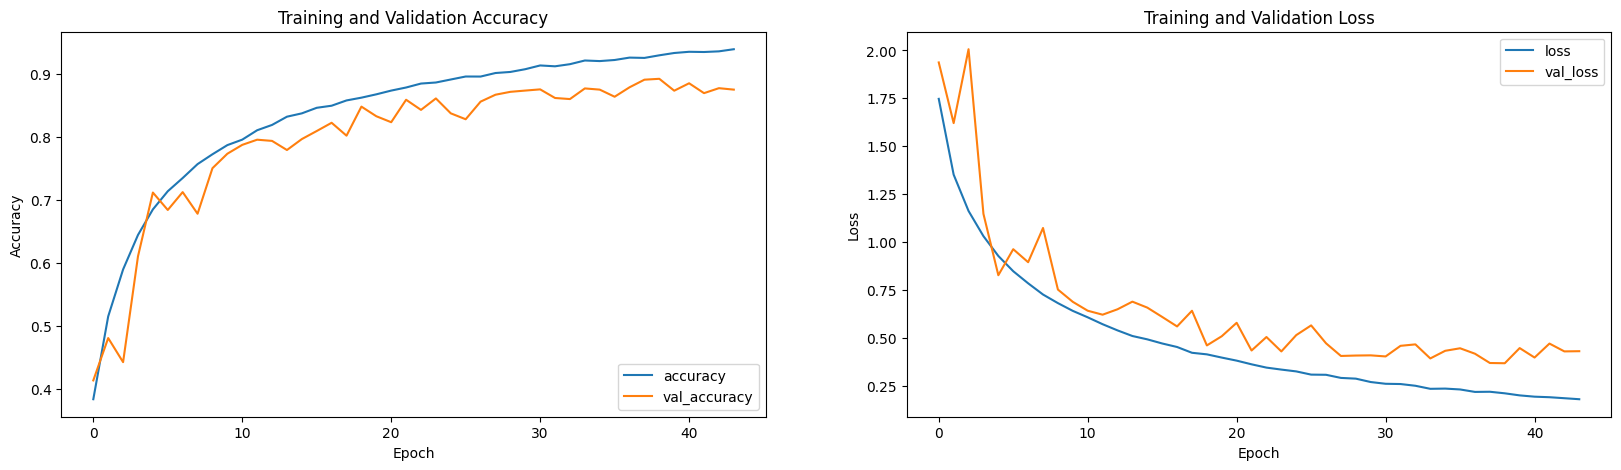

In [21]:
plot_history(history)

I built one final big model based on what performed well previously. I'd say the results are quite satisfactory. Training it took a long time. This dataset is hard, because the images are such low resolution. 

# Test set eval

In [28]:
_, accuracy = model4.evaluate(test_ds)
print(f'Test accuracy: {accuracy:.4f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8853 - loss: 0.3832
Test accuracy: 0.8835


I'm pretty happy with that. I could improve on it some more if I wanted. Maybe try a larger kernel in the first layer and train a little longer with a smaller learning rate. For the sake of this assignment, I think I've done enough.